In [1]:
import itertools
import typing
import logging
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
import time
from pathlib import Path
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import statsmodels.api as statsm

# Self-written modules
from yq.utils.time import timeit
from yq.utils import io
from yq.scripts import models, model_eval
from yq.scripts import heston, gbm
from yq.utils import option
from yq.utils import calendar
from yq.scripts import simulation as sm
from yq.utils import path as yq_path
from yq.utils import log
from sc import constants as cs
from sc import payoff as po

file_location = os.getcwd()
cur_dir = Path(file_location).parent # ipynb cannot use __file__
#cur_dir = Path(__file__).parent
logger_yq = log.setup_logger('yq', yq_path.get_logs_path(cur_dir=cur_dir).joinpath(f"log_file_{datetime.datetime.now().strftime('%Y%m%d_%H')}.log"))
logger_yq.info("\n##########START##########\n")

# Plot the actual price 

<Axes: xlabel='Date'>

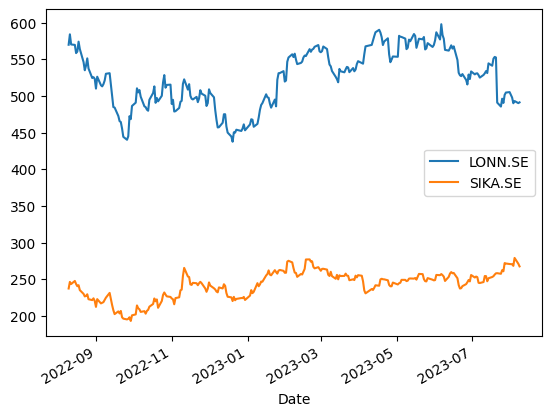

In [2]:
actual_St = po.get_historical_assets_all()
actual_St = actual_St[(actual_St.index > '2022-08-09') & (actual_St.index < '2023-08-09')]
actual_St.plot()

<Axes: xlabel='Date'>

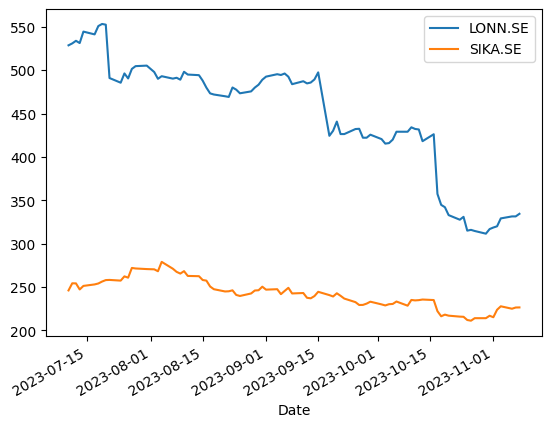

In [3]:
actua_St_ppd = po.get_historical_assets_all()
actua_St_ppd = actua_St_ppd[(actua_St_ppd.index > '2023-07-09') & (actua_St_ppd.index < '2023-11-09')]
actua_St_ppd.plot()


# RMSE Analysis

## Heston and GBM against product price RMSE

In [4]:
heston_rmse = {'heston_20231114_024931_7_0.5_10_56_0.5_unadj': 408.34814595292363, 'heston_20231114_024931_7_0.5_10_56_0.5_adj': 127.81976575281095, 'heston_20231114_025048_7_1.5_10_45_1.5_unadj': 528.3176400710339, 'heston_20231114_025048_7_1.5_10_45_1.5_adj': 91.97531379770524, 'heston_20231114_025152_7_10_10_46_10_unadj': 496.47836157393124, 'heston_20231114_025152_7_10_10_46_10_adj': 85.79926536631463, 'heston_20231114_025252_63_0.5_10_67_0.5_unadj': 273.7084907669089, 'heston_20231114_025252_63_0.5_10_67_0.5_adj': 147.3595859454188, 'heston_20231114_025415_63_1.5_10_67_1.5_unadj': 216.1432727470527, 'heston_20231114_025415_63_1.5_10_67_1.5_adj': 71.10254045643778, 'heston_20231114_025539_63_10_10_67_10_unadj': 168.12169291558578, 'heston_20231114_025539_63_10_10_67_10_adj': 89.76832482921041, 'heston_20231114_025704_252_0.5_10_67_0.5_unadj': 256.57669775506946, 'heston_20231114_025704_252_0.5_10_67_0.5_adj': 138.38886257831848, 'heston_20231114_025829_252_1.5_10_62_1.5_unadj': 310.8028146960057, 'heston_20231114_025829_252_1.5_10_62_1.5_adj': 73.28742299632862, 'heston_20231114_025950_252_10_10_62_10_unadj': 296.12661353849074, 'heston_20231114_025950_252_10_10_62_10_adj': 69.72323253808233, 'heston_20231114_033852_7_0.5_100_56_0.5_unadj': 405.8257658164999, 'heston_20231114_033852_7_0.5_100_56_0.5_adj': 120.73486714684209, 'heston_20231114_034926_7_1.5_100_45_1.5_unadj': 526.4659468665495, 'heston_20231114_034926_7_1.5_100_45_1.5_adj': 59.420511223757565, 'heston_20231114_035807_7_10_100_46_10_unadj': 501.62849891192366, 'heston_20231114_035807_7_10_100_46_10_adj': 58.95230943015451, 'heston_20231114_040708_63_0.5_100_67_0.5_unadj': 246.21997227842763, 'heston_20231114_040708_63_0.5_100_67_0.5_adj': 131.4416542273425, 'heston_20231114_041953_63_1.5_100_67_1.5_unadj': 191.48500814679588, 'heston_20231114_041953_63_1.5_100_67_1.5_adj': 55.83549579583618, 'heston_20231114_043237_63_10_100_67_10_unadj': 137.09704644946243, 'heston_20231114_043237_63_10_100_67_10_adj': 56.42390325189975, 'heston_20231114_044509_252_0.5_100_67_0.5_unadj': 240.42264244557032, 'heston_20231114_044509_252_0.5_100_67_0.5_adj': 128.28047671484475, 'heston_20231114_045744_252_1.5_100_62_1.5_unadj': 310.38595543617794, 'heston_20231114_045744_252_1.5_100_62_1.5_adj': 63.95983896813842, 'heston_20231114_050915_252_10_100_62_10_unadj': 301.76358041296015, 'heston_20231114_050915_252_10_100_62_10_adj': 58.32511651612497, 'heston_20231114_115230_7_0.5_1000_56_0.5_unadj': 409.12446088864215, 'heston_20231114_115230_7_0.5_1000_56_0.5_adj': 116.67859629371215, 'heston_20231114_134109_7_1.5_1000_45_1.5_unadj': 527.9882855257312, 'heston_20231114_134109_7_1.5_1000_45_1.5_adj': 59.49577717212046, 'heston_20231114_151836_7_10_1000_46_10_unadj': 502.26371317427794, 'heston_20231114_151836_7_10_1000_46_10_adj': 57.46546113015327, 'heston_20231114_165326_63_0.5_1000_67_0.5_unadj': 248.38019425786945, 'heston_20231114_165326_63_0.5_1000_67_0.5_adj': 135.23987321124028, 'heston_20231114_191500_63_1.5_1000_67_1.5_unadj': 194.69203599667463, 'heston_20231114_191500_63_1.5_1000_67_1.5_adj': 55.0469729531934, 'heston_20231114_220543_63_10_1000_67_unadj': 143.34715810187706, 'heston_20231114_220543_63_10_1000_67_adj': 56.594021686020994, 'heston_20231115_010234_252_0.5_1000_67_unadj': 245.8918570841682, 'heston_20231115_010234_252_0.5_1000_67_adj': 132.30263135571752, 'heston_20231115_032413_252_1.5_1000_62_unadj': 310.59014578153705, 'heston_20231115_032413_252_1.5_1000_62_adj': 52.47495410270752, 'heston_20231115_051421_252_10_1000_62_unadj': 298.32419065277014, 'heston_20231115_051421_252_10_1000_62_adj': 55.520943146696666}

hrmse_df = pd.DataFrame(list(heston_rmse.items()), columns=['model_id', 'rmse'])
hrmse_df


,model_id,rmse
0,heston_20231114_024931_7_0.5_10_56_0.5_unadj,408.348146
1,heston_20231114_024931_7_0.5_10_56_0.5_adj,127.819766
2,heston_20231114_025048_7_1.5_10_45_1.5_unadj,528.317640
3,heston_20231114_025048_7_1.5_10_45_1.5_adj,91.975314
4,heston_20231114_025152_7_10_10_46_10_unadj,496.478362
5,heston_20231114_025152_7_10_10_46_10_adj,85.799265
6,heston_20231114_025252_63_0.5_10_67_0.5_unadj,273.708491
7,heston_20231114_025252_63_0.5_10_67_0.5_adj,147.359586
8,heston_20231114_025415_63_1.5_10_67_1.5_unadj,216.143273
9,heston_20231114_025415_63_1.5_10_67_1.5_adj,71.102540


In [5]:
gbm_rmse = {'gbm_20231114_024525_7_7_10_67': 104.31957703367053, 
'gbm_20231114_024646_63_63_10_67': 75.48877034902819, 
'gbm_20231114_024808_252_252_10_67': 52.74439988504111, 
'gbm_20231114_030106_7_7_100_67': 85.5957133971566, 
'gbm_20231114_031302_63_63_100_67': 43.664312679503574, 
'gbm_20231114_032613_252_252_100_67': 33.13846477847507, 
'gbm_20231114_052051_7_7_1000_67': 83.24793916264657, 
'gbm_20231114_072227_63_63_1000_67': 37.15403519752636, 
'gbm_20231114_092701_252_252_1000_67': 26.081338271386503}

grmse_df = pd.DataFrame(list(gbm_rmse.items()), columns=['model_id', 'rmse'])
# grmse_df.describe()
grmse_df

,model_id,rmse
0,gbm_20231114_024525_7_7_10_67,104.319577
1,gbm_20231114_024646_63_63_10_67,75.488770
2,gbm_20231114_024808_252_252_10_67,52.744400
3,gbm_20231114_030106_7_7_100_67,85.595713
4,gbm_20231114_031302_63_63_100_67,43.664313
5,gbm_20231114_032613_252_252_100_67,33.138465
6,gbm_20231114_052051_7_7_1000_67,83.247939
7,gbm_20231114_072227_63_63_1000_67,37.154035
8,gbm_20231114_092701_252_252_1000_67,26.081338


In [6]:
hrmse_df[['model', 'date', 'time', 'hist_wdw', 'max_sigma', 'n_sim', 'n_ppd', 'max_sigma2', 'adjustment']] = hrmse_df['model_id'].str.split('_', expand=True)
hrmse_df['adjustment'] = pd.concat([
    hrmse_df['adjustment'].iloc[0:46].reset_index(drop=True), 
    hrmse_df['max_sigma2'].iloc[46:].astype(str).reset_index(drop=True)
], ignore_index=True)
hrmse_df

,model_id,rmse,model,date,time,hist_wdw,max_sigma,n_sim,n_ppd,max_sigma2,adjustment
0,heston_20231114_024931_7_0.5_10_56_0.5_unadj,408.348146,heston,20231114,024931,7,0.5,10,56,0.5,unadj
1,heston_20231114_024931_7_0.5_10_56_0.5_adj,127.819766,heston,20231114,024931,7,0.5,10,56,0.5,adj
2,heston_20231114_025048_7_1.5_10_45_1.5_unadj,528.317640,heston,20231114,025048,7,1.5,10,45,1.5,unadj
3,heston_20231114_025048_7_1.5_10_45_1.5_adj,91.975314,heston,20231114,025048,7,1.5,10,45,1.5,adj
4,heston_20231114_025152_7_10_10_46_10_unadj,496.478362,heston,20231114,025152,7,10,10,46,10,unadj
5,heston_20231114_025152_7_10_10_46_10_adj,85.799265,heston,20231114,025152,7,10,10,46,10,adj
6,heston_20231114_025252_63_0.5_10_67_0.5_unadj,273.708491,heston,20231114,025252,63,0.5,10,67,0.5,unadj
7,heston_20231114_025252_63_0.5_10_67_0.5_adj,147.359586,heston,20231114,025252,63,0.5,10,67,0.5,adj
8,heston_20231114_025415_63_1.5_10_67_1.5_unadj,216.143273,heston,20231114,025415,63,1.5,10,67,1.5,unadj
9,heston_20231114_025415_63_1.5_10_67_1.5_adj,71.102540,heston,20231114,025415,63,1.5,10,67,1.5,adj


In [7]:
grmse_df[['model', 'date', 'time', 'hist_wdw', 'hist_wdw', 'n_sim', 'n_ppd']] = grmse_df['model_id'].str.split('_', expand=True)
grmse_df


,model_id,rmse,model,date,time,hist_wdw,n_sim,n_ppd
0,gbm_20231114_024525_7_7_10_67,104.319577,gbm,20231114,024525,7,10,67
1,gbm_20231114_024646_63_63_10_67,75.488770,gbm,20231114,024646,63,10,67
2,gbm_20231114_024808_252_252_10_67,52.744400,gbm,20231114,024808,252,10,67
3,gbm_20231114_030106_7_7_100_67,85.595713,gbm,20231114,030106,7,100,67
4,gbm_20231114_031302_63_63_100_67,43.664313,gbm,20231114,031302,63,100,67
5,gbm_20231114_032613_252_252_100_67,33.138465,gbm,20231114,032613,252,100,67
6,gbm_20231114_052051_7_7_1000_67,83.247939,gbm,20231114,052051,7,1000,67
7,gbm_20231114_072227_63_63_1000_67,37.154035,gbm,20231114,072227,63,1000,67
8,gbm_20231114_092701_252_252_1000_67,26.081338,gbm,20231114,092701,252,1000,67


In [8]:
grmse_df_sliced = grmse_df[['model', 'hist_wdw', 'n_sim', 'rmse']]
grmse_df_sliced.head()

,model,hist_wdw,n_sim,rmse
0,gbm,7,10,104.319577
1,gbm,63,10,75.488770
2,gbm,252,10,52.744400
3,gbm,7,100,85.595713
4,gbm,63,100,43.664313


In [9]:
hrmse_df_sliced = hrmse_df[['model', 'hist_wdw', 'max_sigma', 'n_sim', 'adjustment', 'rmse']]
hrmse_df_sliced.head()

,model,hist_wdw,max_sigma,n_sim,adjustment,rmse
0,heston,7,0.5,10,unadj,408.348146
1,heston,7,0.5,10,adj,127.819766
2,heston,7,1.5,10,unadj,528.317640
3,heston,7,1.5,10,adj,91.975314
4,heston,7,10,10,unadj,496.478362


In [10]:
# Convert all columns except 'rmse' to integers
columns_to_convert = ['hist_wdw', 'n_sim']
for col in columns_to_convert:
    hrmse_df_sliced[col] = hrmse_df_sliced[col].astype(int)
    grmse_df_sliced[col] = grmse_df_sliced[col].astype(int)

# Format 'rmse' to two decimal places
hrmse_df_sliced['max_sigma'] = hrmse_df_sliced['max_sigma'].astype(float).round(1)
hrmse_df_sliced['rmse'] = hrmse_df_sliced['rmse'].astype(float).round(2)
grmse_df_sliced['rmse'] = grmse_df_sliced['rmse'].astype(float).round(2)

display(hrmse_df_sliced.head())
display(grmse_df_sliced)

/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_47075/4275332876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hrmse_df_sliced[col] = hrmse_df_sliced[col].astype(int)
/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_47075/4275332876.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grmse_df_sliced[col] = grmse_df_sliced[col].astype(int)
/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_47075/4275332876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy

,model,hist_wdw,max_sigma,n_sim,adjustment,rmse
0,heston,7,0.5,10,unadj,408.35
1,heston,7,0.5,10,adj,127.82
2,heston,7,1.5,10,unadj,528.32
3,heston,7,1.5,10,adj,91.98
4,heston,7,10.0,10,unadj,496.48


,model,hist_wdw,n_sim,rmse
0,gbm,7,10,104.32
1,gbm,63,10,75.49
2,gbm,252,10,52.74
3,gbm,7,100,85.60
4,gbm,63,100,43.66
5,gbm,252,100,33.14
6,gbm,7,1000,83.25
7,gbm,63,1000,37.15
8,gbm,252,1000,26.08


In [40]:
hrmse_df_prep = hrmse_df_sliced[hrmse_df_sliced['adjustment'] == 'unadj'].drop(columns='adjustment')
combined_36 = pd.concat([hrmse_df_prep, grmse_df_sliced], axis=0).reset_index(drop=True)
combined_36

,model,hist_wdw,max_sigma,n_sim,rmse
0,heston,7,0.5,10,408.35
1,heston,7,1.5,10,528.32
2,heston,7,10.0,10,496.48
3,heston,63,0.5,10,273.71
4,heston,63,1.5,10,216.14
5,heston,63,10.0,10,168.12
6,heston,252,0.5,10,256.58
7,heston,252,1.5,10,310.80
8,heston,252,10.0,10,296.13
9,heston,7,0.5,100,405.83


In [11]:
hrmse_df_sliced.describe()

,hist_wdw,max_sigma,n_sim,rmse
count,54.000000,54.000000,54.000000,54.000000
mean,107.333333,4.000000,370.000000,204.554630
std,105.802593,4.302259,451.187113,149.588421
min,7.000000,0.500000,10.000000,52.470000
25%,7.000000,0.500000,10.000000,71.647500
50%,63.000000,1.500000,100.000000,140.870000
75%,252.000000,10.000000,1000.000000,297.772500
max,252.000000,10.000000,1000.000000,528.320000


In [12]:
grmse_df_sliced.describe()

,hist_wdw,n_sim,rmse
count,9.000000,9.000000,9.000000
mean,107.333333,370.000000,60.158889
std,111.176661,474.104419,27.644506
min,7.000000,10.000000,26.080000
25%,7.000000,10.000000,37.150000
50%,63.000000,100.000000,52.740000
75%,252.000000,1000.000000,83.250000
max,252.000000,1000.000000,104.320000


In [13]:
hrmse_df_sliced.sort_values(by='rmse', ascending=True).head()

,model,hist_wdw,max_sigma,n_sim,adjustment,rmse
51,heston,252,1.5,1000,adj,52.47
45,heston,63,1.5,1000,adj,55.05
53,heston,252,10.0,1000,adj,55.52
27,heston,63,1.5,100,adj,55.84
29,heston,63,10.0,100,adj,56.42


Text(0.5, 1.0, 'Adjustment vs RMSE')

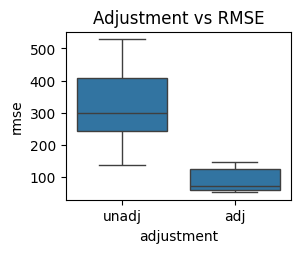

In [14]:
# Box plot for 'adjustment' vs 'rmse'
plt.subplot(2, 2, 2)
sns.boxplot(data=hrmse_df_sliced, x='adjustment', y='rmse')
plt.title('Adjustment vs RMSE')

Text(0.5, 1.0, 'Effect of hist_wdw on RMSE')

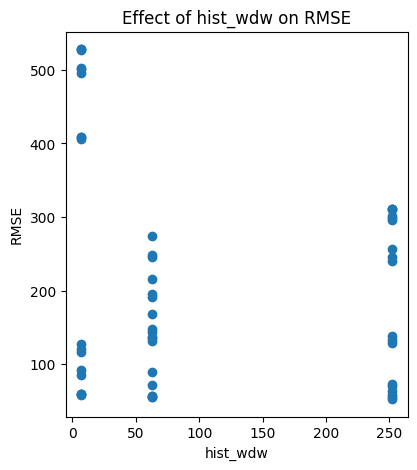

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(hrmse_df_sliced['hist_wdw'], hrmse_df_sliced['rmse'])
plt.xlabel('hist_wdw')
plt.ylabel('RMSE')
plt.title('Effect of hist_wdw on RMSE')

Text(0.5, 1.0, 'Effect of max_sigma on RMSE')

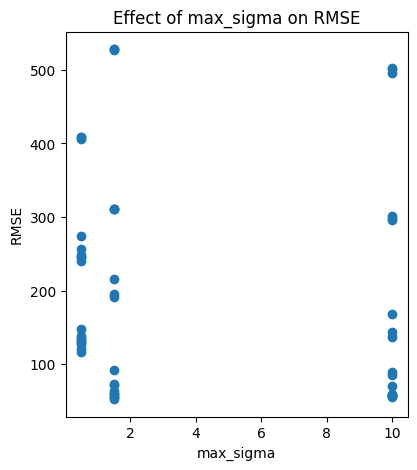

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(hrmse_df_sliced['max_sigma'], hrmse_df_sliced['rmse'])
plt.xlabel('max_sigma')
plt.ylabel('RMSE')
plt.title('Effect of max_sigma on RMSE')

# Not very clear but max_sigma = 0.5 seem to perform worse

Text(0.5, 1.0, 'Effect of n_sim on RMSE')

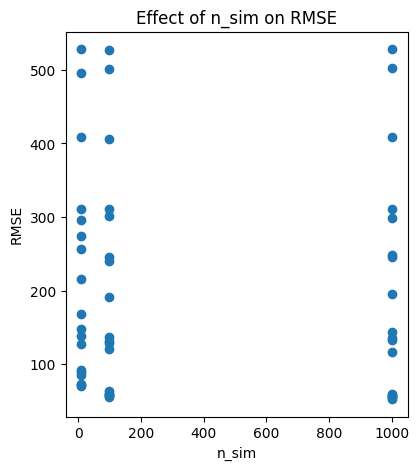

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(hrmse_df_sliced['n_sim'], hrmse_df_sliced['rmse'])
plt.xlabel('n_sim')
plt.ylabel('RMSE')
plt.title('Effect of n_sim on RMSE')

# More simulations does not clearly lead to better results

In [18]:
hrmse_1 = hrmse_df_sliced.drop(columns='adjustment')

In [19]:
hrmse_2 = hrmse_1.sort_values(by='rmse', ascending=True).reset_index(drop=True).head(10)
hrmse_2

,model,hist_wdw,max_sigma,n_sim,rmse
0,heston,252,1.5,1000,52.47
1,heston,63,1.5,1000,55.05
2,heston,252,10.0,1000,55.52
3,heston,63,1.5,100,55.84
4,heston,63,10.0,100,56.42
5,heston,63,10.0,1000,56.59
6,heston,7,10.0,1000,57.47
7,heston,252,10.0,100,58.33
8,heston,7,10.0,100,58.95
9,heston,7,1.5,100,59.42


In [20]:
hrmse_2.groupby('max_sigma')['rmse'].count()

max_sigma
1.5     4
10.0    6
Name: rmse, dtype: int64

In [21]:
hrmse_2 = hrmse_1.sort_values(by='rmse', ascending=True).reset_index(drop=True).head(10)
hrmse_2

,model,hist_wdw,max_sigma,n_sim,rmse
0,heston,252,1.5,1000,52.47
1,heston,63,1.5,1000,55.05
2,heston,252,10.0,1000,55.52
3,heston,63,1.5,100,55.84
4,heston,63,10.0,100,56.42
5,heston,63,10.0,1000,56.59
6,heston,7,10.0,1000,57.47
7,heston,252,10.0,100,58.33
8,heston,7,10.0,100,58.95
9,heston,7,1.5,100,59.42


In [22]:
grmse_1 = grmse_df_sliced.sort_values(by='rmse').reset_index(drop=True)
grmse_1
# ID 4 with n_sim 10 is as good as heston n_sim 100 (ID 0)

,model,hist_wdw,n_sim,rmse
0,gbm,252,1000,26.08
1,gbm,252,100,33.14
2,gbm,63,1000,37.15
3,gbm,63,100,43.66
4,gbm,252,10,52.74
5,gbm,63,10,75.49
6,gbm,7,1000,83.25
7,gbm,7,100,85.60
8,gbm,7,10,104.32


In [23]:
comb = pd.concat([grmse_1, hrmse_2], axis=0).sort_values(by='rmse').reset_index(drop=True)
comb = comb[['model', 'hist_wdw', 'n_sim', 'max_sigma', 'rmse']]
comb

,model,hist_wdw,n_sim,max_sigma,rmse
0,gbm,252,1000,NaN,26.08
1,gbm,252,100,NaN,33.14
2,gbm,63,1000,NaN,37.15
3,gbm,63,100,NaN,43.66
4,heston,252,1000,1.5,52.47
5,gbm,252,10,NaN,52.74
6,heston,63,1000,1.5,55.05
7,heston,252,1000,10.0,55.52
8,heston,63,100,1.5,55.84
9,heston,63,100,10.0,56.42


Text(0.5, 1.0, 'Effect of hist_wdw on RMSE')

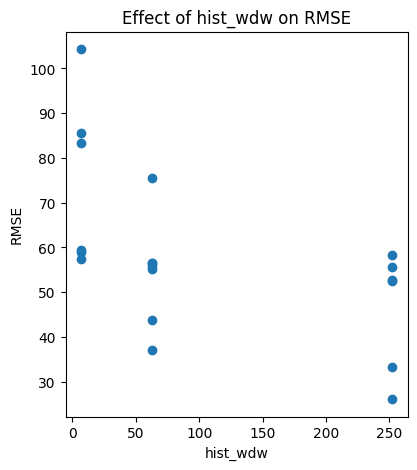

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(comb['hist_wdw'], comb['rmse'])
plt.xlabel('hist_wdw')
plt.ylabel('RMSE')
plt.title('Effect of hist_wdw on RMSE')
# Higher hist_wdw is better

In [25]:
comb_2 = comb[comb['hist_wdw'] > 7].sort_values(by='rmse').reset_index(drop=True)
comb_2

,model,hist_wdw,n_sim,max_sigma,rmse
0,gbm,252,1000,NaN,26.08
1,gbm,252,100,NaN,33.14
2,gbm,63,1000,NaN,37.15
3,gbm,63,100,NaN,43.66
4,heston,252,1000,1.5,52.47
5,gbm,252,10,NaN,52.74
6,heston,63,1000,1.5,55.05
7,heston,252,1000,10.0,55.52
8,heston,63,100,1.5,55.84
9,heston,63,100,10.0,56.42


Text(0.5, 1.0, 'Effect of n_sim on RMSE')

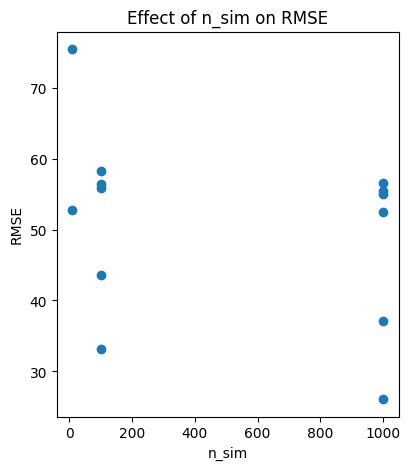

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(comb_2['n_sim'], comb_2['rmse'])
plt.xlabel('n_sim')
plt.ylabel('RMSE')
plt.title('Effect of n_sim on RMSE')

In [31]:
com_3 = comb_2.head(10)

com_3

,model,hist_wdw,n_sim,max_sigma,rmse
0,gbm,252,1000,NaN,26.08
1,gbm,252,100,NaN,33.14
2,gbm,63,1000,NaN,37.15
3,gbm,63,100,NaN,43.66
4,heston,252,1000,1.5,52.47
5,gbm,252,10,NaN,52.74
6,heston,63,1000,1.5,55.05
7,heston,252,1000,10.0,55.52
8,heston,63,100,1.5,55.84
9,heston,63,100,10.0,56.42


In [28]:
com_3[com_3.index == 5]

,model,hist_wdw,n_sim,max_sigma,rmse
5,gbm,252,10,NaN,52.74


## Simulated paths against UA RMSE (break down into LONN and SIKA? or combined)

In [29]:
def extract_file_name_gbm(input_string):
    # Split the string using underscore as the delimiter
    parts = input_string.split('_')
    date_time = parts[0] + '_' + parts[1]
    hist_wdw = parts[2]

    return date_time, hist_wdw

def extract_file_name_heston(input_string):
    # Split the string using underscore as the delimiter
    parts = input_string.split('_')
    date_time = parts[0] + '_' + parts[1]
    hist_wdw = parts[2]
    max_sigma = parts[3]


    return date_time, hist_wdw, max_sigma


In [30]:
# Function parameters
model = 'gbm'
gbm_files = ["20231114_024808_252"] # GBM champion: 20231114_092701_252. heston 20231115_032413_252_1.5 # TODO: heston need adjust

# RMSE dict for each ppd
for uid in gbm_files:

    print(uid)
    # Getting back the strings, rmb to convert to the dtype if needed
    if model == 'gbm':
        time_str, hist_wdw = extract_file_name_gbm(uid)
        print(time_str, hist_wdw)
    else:
        date_time, hist_wdw, max_sigma = extract_file_name_heston(uid)
        print(date_time, hist_wdw, max_sigma)

    paths_arr, dates = sm.read_sim_data(model, uid, cs.INITIAL_PROD_PRICING_DATE, cs.FINAL_PROD_PRICING_DATE)
    n_sim = len(paths_arr[0])
    n_ppd = len(paths_arr) # Some missing lists in n_ppd
    print(n_sim, n_ppd)

    # For each ppd/simulation date, we have many paths. Take average, each asset with its asset price
    # The dates for the path need to be sliced (first day of sim to last day of avai data by sc func)
    for ppd in range(1): # TODO: Do for 1 path first
        RMSE_dict = {}
        RMSE_list = []
        actual_St = po.get_historical_assets_all()
        sim_start_date = paths_arr[ppd][0].first_valid_index()
        actual_St = actual_St[(actual_St.index >= sim_start_date)]
        actual_St.columns = [f'actual_{name}' for name in actual_St.columns]
        avai_end_date = actual_St.last_valid_index()
        print(avai_end_date)
        display(actual_St.head())
        # Concat all the UA prediction across all sims
        # Then take all the sims average groupby the date of sim
        paths = pd.DataFrame() 

        plt.subplots(figsize=(10, 6))
        plt.tight_layout()
        plt.tight_layout() # TODO:
        title_str = f"Simulated Paths Against Actual Share Price"
        subtitle_str = f"Model: {model}, sim_start: {sim_start_date}, hist_wdw: {hist_wdw}, n_sim: {n_sim}, n_ppd: {n_ppd}"
        plt.title(f"{title_str}\n{subtitle_str}")  # Adjust font size as needed
            
        # Concat and TODO: plot graph
        for sim in range(n_sim):
            path = paths_arr[ppd][sim]
            path = path[path.index <= avai_end_date]
            display(f"Path:\n{path}")
            paths = pd.concat([paths, path], axis=0)

            for asset in cs.ASSET_NAMES:
                plt.plot(path.index, path[asset], alpha=0.5, label=f'sim_{asset}')  

        for asset in cs.ASSET_NAMES:
            plt.plot(actual_St.index, actual_St, alpha=1, label=f'actual_{asset}')
        # path.plot()
        plt.show()
        plt.close()

        display(len(paths) == len(actual_St) * n_sim)
        display(len(actual_St))
        display(len(paths))

        # Get average
        paths_mean = paths.groupby(paths.index).mean()

         # Concat axis=1 with actual price
        if (len(paths_mean) == len(actual_St)):
            St_compare = pd.concat([paths_mean, actual_St], axis=1)
            display(St_compare.head())
        else:
            print("Error with length")

         # Get RMSE
        for asset in cs.ASSET_NAMES:
            RMSE  = np.sqrt(np.mean((St_compare[asset] - 
                                     St_compare[f'actual_{asset}']) ** 2))
            RMSE_dict[f'{asset}_RMSE'] = RMSE
            RMSE_list.append(RMSE.round(2))
            
            
        display(RMSE_dict)
        plt.subplots(figsize=(10, 6))
        plt.tight_layout()
        plt.tight_layout() # TODO:
        title_str = f"Simulated Paths Against Actual Share Price"
        subtitle_str = f"Model: {model}, sim_start: {sim_start_date}, hist_wdw: {hist_wdw}, n_sim: {n_sim}, n_ppd: {n_ppd}, RMSE: {RMSE_list}"
        plt.title(f"{title_str}\n{subtitle_str}")  # Adjust font size as needed

        for asset in cs.ASSET_NAMES:
            plt.plot(paths_mean.index, paths_mean[asset], alpha=0.5, label=f'sim_{asset}')  

        for asset in cs.ASSET_NAMES:
            plt.plot(actual_St.index, actual_St, alpha=1, label=f'actual_{asset}')
        # path.plot()
        plt.show()
        plt.close()

        

       







20231114_024808_252
20231114_024808 252


IndexError: list index out of range

20231114_025829_252_1.5
20231114_025829 252 1.5
10 62
2023-11-10 00:00:00


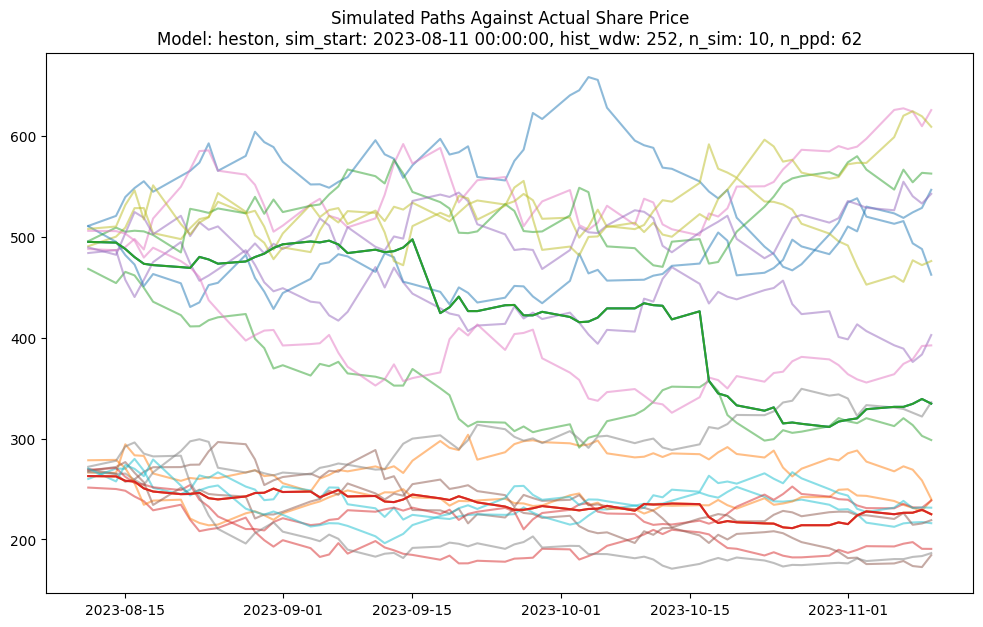

{'LONN.SE_RMSE': 88.62728127800797, 'SIKA.SE_RMSE': 11.437384803774561}

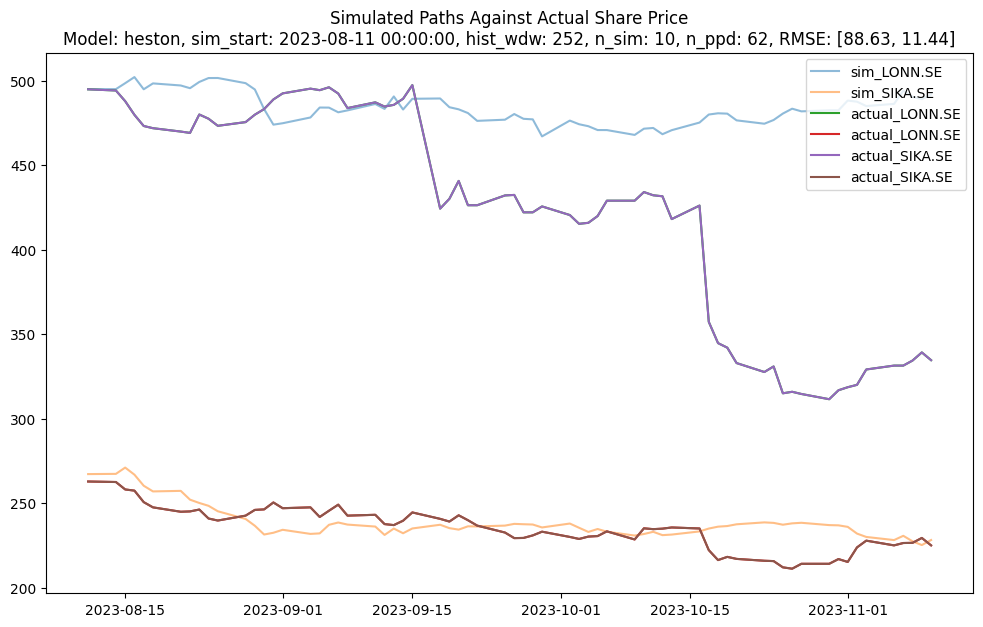

In [ ]:
model = 'heston'
heston_files = ["20231114_025829_252_1.5"] # GBM champion: 20231114_092701_252. heston 20231115_032413_252_1.5 # TODO: heston need adjust
# Test GBM: 20231114_024808_252
# RMSE dict for each ppd

for uid in heston_files:

    print(uid)
    # Getting back the strings, rmb to convert to the dtype if needed
    if model == 'gbm':
        time_str, hist_wdw = extract_file_name_gbm(uid)
        print(time_str, hist_wdw)
    else:
        date_time, hist_wdw, max_sigma = extract_file_name_heston(uid)
        print(date_time, hist_wdw, max_sigma)

    paths_arr, dates = sm.read_sim_data(model, uid, cs.INITIAL_PROD_PRICING_DATE, cs.FINAL_PROD_PRICING_DATE)
    n_sim = len(paths_arr[0])
    n_ppd = len(paths_arr) # Some missing lists in n_ppd
    print(n_sim, n_ppd)

    # For each ppd/simulation date, we have many paths. Take average, each asset with its asset price
    # The dates for the path need to be sliced (first day of sim to last day of avai data by sc func)
    
    for ppd in range(1): # TODO: Do for 1 path first
        RMSE_dict = {}
        RMSE_list = []
        actual_St = po.get_historical_assets_all()
        sim_start_date = paths_arr[ppd][0].first_valid_index()
        actual_St = actual_St[(actual_St.index >= sim_start_date)]
        actual_St.columns = [f'actual_{name}' for name in actual_St.columns]
        avai_end_date = actual_St.last_valid_index()
        print(avai_end_date)
        #display(actual_St.head())
        # Concat all the UA prediction across all sims
        # Then take all the sims average groupby the date of sim
        paths = pd.DataFrame() 

        plt.subplots(figsize=(10, 6))
        plt.tight_layout()
        plt.tight_layout() # TODO:
        title_str = f"Simulated Paths Against Actual Share Price"
        subtitle_str = f"Model: {model}, sim_start: {sim_start_date}, hist_wdw: {hist_wdw}, n_sim: {n_sim}, n_ppd: {n_ppd}"
        plt.title(f"{title_str}\n{subtitle_str}")  # Adjust font size as needed
            
        # Concat and TODO: plot graph
        for sim in range(n_sim):
            path = paths_arr[ppd][sim]
            path = path[path.index <= avai_end_date]
            #display(f"Path:\n{path}")
            paths = pd.concat([paths, path], axis=0)

            for asset in cs.ASSET_NAMES:
                plt.plot(path.index, path[asset], alpha=0.5, label=f'sim_{asset}')  

        for asset in cs.ASSET_NAMES:
            plt.plot(actual_St.index, actual_St, alpha=1, label=f'actual_{asset}')
        # path.plot()
        # stor_dir = yq_path.get_plots_path(Path(os.getwd()).parent).joinpath('eval', model)
        # file_path = stor_dir.joinpath(f'{model}_{uid}_{n_sim}_{n_ppd}_asset.png')
        # stor_dir.mkdir(parents=True, exist_ok=True)
        # plt.savefig(file_path, bbox_inches='tight')
        plt.show()
        plt.close()

        #display(len(paths) == len(actual_St) * n_sim)
        #display(len(actual_St))
        #display(len(paths))

        # Get average
        paths_mean = paths.groupby(paths.index).mean()

        # Concat axis=1 with actual price
        if (len(paths_mean) == len(actual_St)):
            St_compare = pd.concat([paths_mean, actual_St], axis=1)
            # display(St_compare.head())
        else:
            print("Error with length")

        # Get RMSE
        for asset in cs.ASSET_NAMES:
            RMSE  = np.sqrt(np.mean((St_compare[asset] - 
                                    St_compare[f'actual_{asset}']) ** 2))
            RMSE_dict[f'{asset}_RMSE'] = RMSE
            RMSE_list.append(RMSE.round(2))
            
            
        display(RMSE_dict)
        plt.subplots(figsize=(10, 6))
        plt.tight_layout()
        plt.tight_layout() # TODO:
        title_str = f"Simulated Paths Against Actual Share Price"
        subtitle_str = f"Model: {model}, sim_start: {sim_start_date}, hist_wdw: {hist_wdw}, n_sim: {n_sim}, n_ppd: {n_ppd}, RMSE: {RMSE_list}"
        plt.title(f"{title_str}\n{subtitle_str}")  # Adjust font size as needed

        for asset in cs.ASSET_NAMES:
            plt.plot(paths_mean.index, paths_mean[asset], alpha=0.5, label=f'sim_{asset}')  

        for asset in cs.ASSET_NAMES:
            plt.plot(actual_St.index, actual_St, alpha=1, label=f'actual_{asset}')
        # path.plot()
        plt.legend(loc='upper right')
        # stor_dir = yq_path.get_plots_path(Path(__file__).parent).joinpath('eval', model)
        # file_path = stor_dir.joinpath(f'{model}_{uid}_{n_sim}_{n_ppd}_mean_asset.png')
        # stor_dir.mkdir(parents=True, exist_ok=True)
        # plt.savefig(file_path, bbox_inches='tight')

        plt.show()
        plt.close()

20231114_025415_63_1.5
20231114_025415 63 1.5
10 67
2023-11-10 00:00:00


,actual_LONN.SE,actual_SIKA.SE
Date,,
2023-08-10,498.1,268.3
2023-08-11,494.9,262.8
2023-08-14,494.2,262.5
2023-08-15,487.9,258.1
2023-08-16,479.8,257.4


'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  500.591584  262.888455\n2023-08-11  513.931173  265.341051\n2023-08-14  528.926580  275.561176\n2023-08-15  519.489368  283.618198\n2023-08-16  501.300301  289.704443\n2023-08-17  475.610373  290.309783\n2023-08-18  475.206401  291.788828\n2023-08-21  505.874253  316.085729\n2023-08-22  501.129360  318.997523\n2023-08-23  498.455190  313.611320\n2023-08-24  493.181882  317.655139\n2023-08-25  488.339836  304.086091\n2023-08-28  493.284186  303.180736\n2023-08-29  480.983885  291.390199\n2023-08-30  459.306365  285.401058\n2023-08-31  476.355159  283.001068\n2023-09-01  463.425548  285.614542\n2023-09-04  487.951672  277.806353\n2023-09-05  470.123383  273.742053\n2023-09-06  465.907331  263.625623\n2023-09-07  462.261570  255.771928\n2023-09-08  481.281558  262.902790\n2023-09-11  509.916944  273.211952\n2023-09-12  524.132176  278.452560\n2023-09-13  511.410708  270.988979\n2023-09-14  488.4789

'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  500.817856  276.762892\n2023-08-11  469.637651  262.740315\n2023-08-14  449.245545  266.286040\n2023-08-15  461.021475  266.536568\n2023-08-16  496.239756  284.973657\n2023-08-17  480.590956  282.171949\n2023-08-18  489.145298  286.963796\n2023-08-21  478.069918  302.136907\n2023-08-22  474.685658  308.819904\n2023-08-23  486.887672  316.027236\n2023-08-24  485.948796  312.153543\n2023-08-25  493.883072  319.432197\n2023-08-28  525.459201  316.146249\n2023-08-29  541.347301  315.727470\n2023-08-30  567.425326  320.302313\n2023-08-31  523.906343  307.918873\n2023-09-01  555.933933  318.761999\n2023-09-04  524.553286  318.498037\n2023-09-05  534.347366  327.847476\n2023-09-06  541.373905  322.556137\n2023-09-07  540.091219  316.514989\n2023-09-08  538.565585  321.188987\n2023-09-11  560.488279  323.730216\n2023-09-12  553.795690  334.643994\n2023-09-13  543.292962  336.754314\n2023-09-14  531.3059

'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  484.961312  271.331487\n2023-08-11  483.089200  264.948473\n2023-08-14  486.692864  250.990542\n2023-08-15  477.659822  241.237371\n2023-08-16  474.963083  237.504869\n2023-08-17  465.799212  248.149330\n2023-08-18  467.442944  245.397537\n2023-08-21  443.415292  236.591722\n2023-08-22  438.813167  223.427613\n2023-08-23  439.286488  223.833610\n2023-08-24  459.165253  224.469742\n2023-08-25  469.290863  228.825091\n2023-08-28  461.656062  234.595842\n2023-08-29  455.192576  234.320555\n2023-08-30  470.205742  219.044744\n2023-08-31  463.672605  221.443032\n2023-09-01  461.690236  214.909298\n2023-09-04  477.249187  217.720682\n2023-09-05  514.035492  216.159025\n2023-09-06  479.982493  209.516461\n2023-09-07  469.725291  211.058679\n2023-09-08  492.458379  227.612808\n2023-09-11  479.070665  215.423951\n2023-09-12  491.084884  219.097672\n2023-09-13  494.694337  214.932950\n2023-09-14  501.8158

'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  511.312261  268.844411\n2023-08-11  505.801415  272.428493\n2023-08-14  490.662917  265.149467\n2023-08-15  456.952758  260.726963\n2023-08-16  460.394113  271.645513\n2023-08-17  451.181706  265.232749\n2023-08-18  469.307493  267.980291\n2023-08-21  470.822016  280.383229\n2023-08-22  487.491227  278.210184\n2023-08-23  510.197872  285.147128\n2023-08-24  506.679760  276.312576\n2023-08-25  486.077680  274.046572\n2023-08-28  453.793174  257.152757\n2023-08-29  445.403770  252.708035\n2023-08-30  456.305047  261.092293\n2023-08-31  451.438161  250.972439\n2023-09-01  426.442098  245.761835\n2023-09-04  428.713758  247.347343\n2023-09-05  409.321234  247.656703\n2023-09-06  404.405192  241.523402\n2023-09-07  423.801824  245.054138\n2023-09-08  400.882475  232.531709\n2023-09-11  402.369852  232.547427\n2023-09-12  398.663433  227.026569\n2023-09-13  417.174140  226.973557\n2023-09-14  415.3234

'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  456.406304  252.912781\n2023-08-11  481.017385  255.551847\n2023-08-14  474.371144  253.614260\n2023-08-15  496.496325  267.840798\n2023-08-16  523.680205  273.094773\n2023-08-17  503.156311  280.088388\n2023-08-18  511.634972  285.526306\n2023-08-21  490.691830  276.889151\n2023-08-22  476.683391  284.294238\n2023-08-23  463.441519  277.610702\n2023-08-24  465.421523  278.683404\n2023-08-25  459.740182  280.514166\n2023-08-28  452.147050  264.189383\n2023-08-29  459.094997  268.238098\n2023-08-30  494.789862  272.396549\n2023-08-31  448.529728  268.347706\n2023-09-01  450.452269  256.927879\n2023-09-04  453.205950  270.469565\n2023-09-05  443.632702  262.437959\n2023-09-06  424.600145  262.165954\n2023-09-07  421.329415  262.883424\n2023-09-08  443.562149  271.863008\n2023-09-11  452.959860  270.570780\n2023-09-12  464.586543  272.659322\n2023-09-13  481.809832  284.443809\n2023-09-14  488.5402

'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  493.208910  259.486363\n2023-08-11  466.029997  254.764103\n2023-08-14  476.605441  249.927122\n2023-08-15  466.509564  245.134039\n2023-08-16  465.132060  233.970624\n2023-08-17  483.820973  246.884130\n2023-08-18  481.664788  242.180519\n2023-08-21  458.173550  232.156953\n2023-08-22  463.191301  227.263150\n2023-08-23  486.642513  212.840819\n2023-08-24  450.717814  204.279115\n2023-08-25  461.685954  203.441219\n2023-08-28  464.796935  200.847196\n2023-08-29  453.040257  207.977920\n2023-08-30  448.875437  204.216370\n2023-08-31  437.128918  191.551278\n2023-09-01  430.120006  188.251174\n2023-09-04  416.662095  191.570287\n2023-09-05  427.187259  197.270905\n2023-09-06  420.466481  190.036405\n2023-09-07  425.886814  192.252968\n2023-09-08  421.151415  200.963204\n2023-09-11  398.518439  189.702229\n2023-09-12  401.344550  188.300491\n2023-09-13  383.000992  183.974894\n2023-09-14  377.2111

'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  476.207454  244.206793\n2023-08-11  471.596100  243.110480\n2023-08-14  483.494401  229.616203\n2023-08-15  494.083281  222.071034\n2023-08-16  485.467435  219.205088\n2023-08-17  497.943198  217.526440\n2023-08-18  525.023349  214.730470\n2023-08-21  519.298306  205.943420\n2023-08-22  517.416832  201.375128\n2023-08-23  497.923991  196.275060\n2023-08-24  500.081477  204.048595\n2023-08-25  478.041027  196.907184\n2023-08-28  491.013452  195.676982\n2023-08-29  472.753089  184.826519\n2023-08-30  480.928569  188.483391\n2023-08-31  498.753657  192.992211\n2023-09-01  510.934473  192.681321\n2023-09-04  529.164464  206.980897\n2023-09-05  549.140477  202.848757\n2023-09-06  550.790807  206.648150\n2023-09-07  560.314955  215.236654\n2023-09-08  563.511539  212.990562\n2023-09-11  552.822885  210.134150\n2023-09-12  566.269724  211.972546\n2023-09-13  603.122748  218.735969\n2023-09-14  604.2485

'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  502.430656  246.077550\n2023-08-11  479.963679  239.982539\n2023-08-14  502.998873  257.887580\n2023-08-15  511.685467  259.065669\n2023-08-16  494.373077  255.520864\n2023-08-17  485.559450  242.018679\n2023-08-18  513.950171  239.173941\n2023-08-21  523.336541  244.428473\n2023-08-22  539.560665  249.538906\n2023-08-23  570.547174  255.875023\n2023-08-24  579.458649  261.588650\n2023-08-25  582.440892  273.858865\n2023-08-28  577.038223  280.941438\n2023-08-29  565.751166  270.804352\n2023-08-30  579.686882  268.913223\n2023-08-31  587.480717  284.015336\n2023-09-01  593.972652  280.687011\n2023-09-04  620.357910  276.161229\n2023-09-05  613.094400  269.863881\n2023-09-06  614.970608  269.960767\n2023-09-07  584.697077  254.703809\n2023-09-08  566.265684  252.333743\n2023-09-11  566.027173  263.270522\n2023-09-12  550.647585  253.629032\n2023-09-13  536.280061  247.138628\n2023-09-14  583.1172

'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  465.876250  252.476842\n2023-08-11  469.107736  244.451010\n2023-08-14  483.753715  252.534156\n2023-08-15  511.665336  268.642254\n2023-08-16  527.225775  271.939649\n2023-08-17  542.874292  278.006162\n2023-08-18  519.992491  270.160718\n2023-08-21  514.646554  264.492700\n2023-08-22  508.794343  275.673825\n2023-08-23  493.966197  273.690809\n2023-08-24  493.359257  275.954174\n2023-08-25  505.428795  279.757923\n2023-08-28  520.844415  288.652836\n2023-08-29  527.749572  292.532892\n2023-08-30  532.742319  290.526865\n2023-08-31  532.476362  284.831157\n2023-09-01  527.046521  285.489539\n2023-09-04  524.358839  291.177210\n2023-09-05  504.124890  280.971541\n2023-09-06  505.540303  276.678336\n2023-09-07  478.363050  270.266432\n2023-09-08  475.820246  275.040266\n2023-09-11  479.510594  276.556406\n2023-09-12  478.581298  283.849000\n2023-09-13  490.837576  281.788987\n2023-09-14  487.6413

'Path:\n               LONN.SE     SIKA.SE\nDate                              \n2023-08-10  442.891996  249.973138\n2023-08-11  429.437491  252.051753\n2023-08-14  415.124597  237.273016\n2023-08-15  383.517970  236.076150\n2023-08-16  398.434856  244.454918\n2023-08-17  388.722241  234.126224\n2023-08-18  391.899841  231.170796\n2023-08-21  381.031705  229.557360\n2023-08-22  410.780297  234.816288\n2023-08-23  408.035528  232.314842\n2023-08-24  386.004089  224.664136\n2023-08-25  385.772025  220.091210\n2023-08-28  384.071343  211.371320\n2023-08-29  370.133401  214.415151\n2023-08-30  373.527984  211.503076\n2023-08-31  378.554261  205.986847\n2023-09-01  381.827909  207.753826\n2023-09-04  393.799884  212.796535\n2023-09-05  410.552735  223.652212\n2023-09-06  410.618005  218.252036\n2023-09-07  410.814581  209.745839\n2023-09-08  413.540530  222.602522\n2023-09-11  415.414979  221.553233\n2023-09-12  430.039760  227.703639\n2023-09-13  429.792070  236.521210\n2023-09-14  419.9762

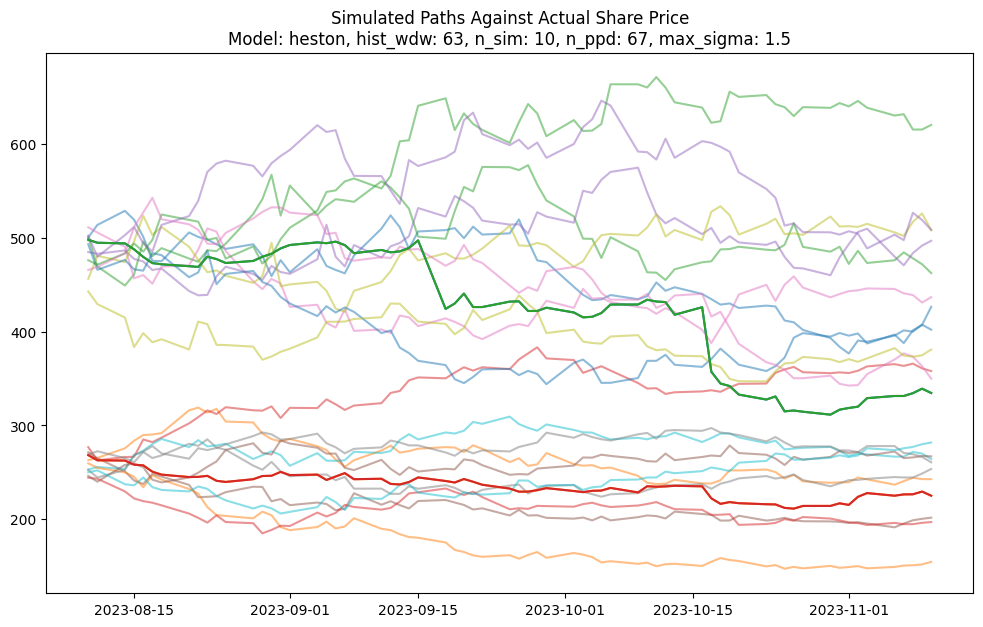

True

67

670

,LONN.SE,SIKA.SE,actual_LONN.SE,actual_SIKA.SE
Date,,,,
2023-08-10,483.470458,258.496071,498.1,268.3
2023-08-11,476.961183,255.537006,494.9,262.8
2023-08-14,479.187608,253.883956,494.2,262.5
2023-08-15,477.908137,255.094904,487.9,258.1
2023-08-16,482.721066,258.201440,479.8,257.4


{'LONN.SE_RMSE': 79.33910409506446, 'SIKA.SE_RMSE': 19.066846650879818}

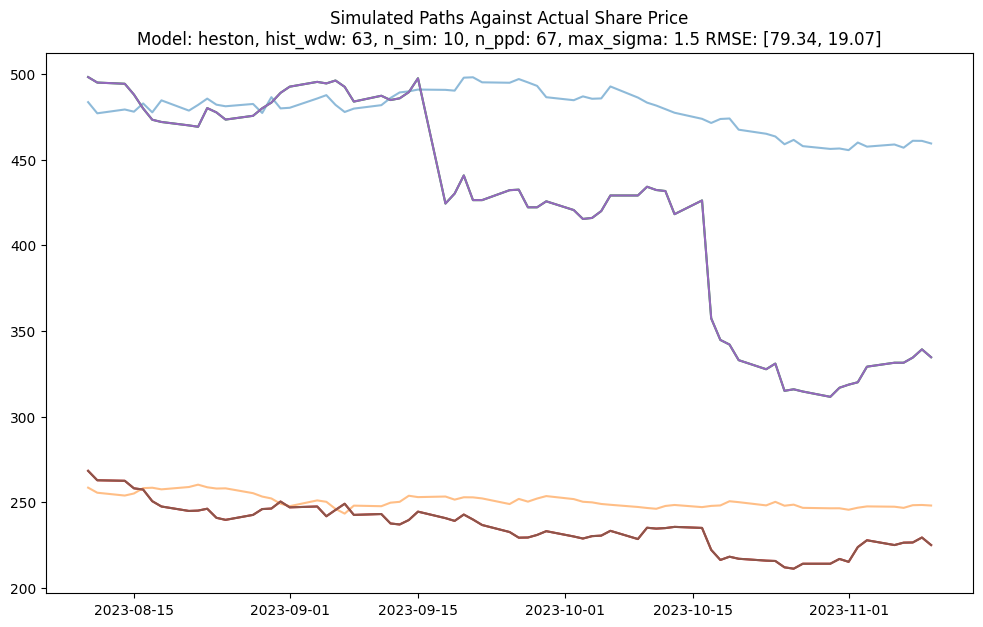

In [ ]:
# Function parameters
model = 'heston'
heston_files = ["20231114_025415_63_1.5"] # GBM champion: 20231114_092701_252. heston 20231115_032413_252_1.5 # TODO: heston need adjust

# RMSE dict for each ppd
RMSE_dict = {}
RMSE_list = []
for uid in heston_files:

    print(uid)
    # Getting back the strings, rmb to convert to the dtype if needed
    if model == 'gbm':
        time_str, hist_wdw = extract_file_name_gbm(uid)
        print(time_str, hist_wdw)
    else:
        date_time, hist_wdw, max_sigma = extract_file_name_heston(uid)
        print(date_time, hist_wdw, max_sigma)

    paths_arr, dates = sm.read_sim_data(model, uid, cs.INITIAL_PROD_PRICING_DATE, cs.FINAL_PROD_PRICING_DATE)
    n_sim = len(paths_arr[0])
    n_ppd = len(paths_arr) # Some missing lists in n_ppd
    print(n_sim, n_ppd)

    # For each ppd/simulation date, we have many paths. Take average, each asset with its asset price
    # The dates for the path need to be sliced (first day of sim to last day of avai data by sc func)
    for ppd in range(1): # TODO: Do for 1 path first
        actual_St = po.get_historical_assets_all()
        sim_start_date = paths_arr[ppd][0].first_valid_index()
        actual_St = actual_St[(actual_St.index >= sim_start_date)]
        actual_St.columns = [f'actual_{name}' for name in actual_St.columns]
        avai_end_date = actual_St.last_valid_index()
        print(avai_end_date)
        display(actual_St.head())
        # Concat all the UA prediction across all sims
        # Then take all the sims average groupby the date of sim
        paths = pd.DataFrame() 

        plt.subplots(figsize=(10, 6))
        plt.tight_layout()
        plt.tight_layout() # TODO:
        title_str = f"Simulated Paths Against Actual Share Price"
        subtitle_str = f"Model: {model}, hist_wdw: {hist_wdw}, n_sim: {n_sim}, n_ppd: {n_ppd}, max_sigma: {max_sigma}"
        plt.title(f"{title_str}\n{subtitle_str}")  # Adjust font size as needed
            
        # Concat and TODO: plot graph
        for sim in range(n_sim):
            path = paths_arr[ppd][sim]
            path = path[path.index <= avai_end_date]
            display(f"Path:\n{path}")
            paths = pd.concat([paths, path], axis=0)

            for asset in cs.ASSET_NAMES:
                plt.plot(path.index, path[asset], alpha=0.5, label=f'sim_{asset}')  

        for asset in cs.ASSET_NAMES:
            plt.plot(actual_St.index, actual_St, alpha=1, label=f'actual_{asset}')
        # path.plot()
        plt.show()
        plt.close()

        display(len(paths) == len(actual_St) * n_sim)
        display(len(actual_St))
        display(len(paths))

        # Get average
        paths_mean = paths.groupby(paths.index).mean()

         # Concat axis=1 with actual price
        if (len(paths_mean) == len(actual_St)):
            St_compare = pd.concat([paths_mean, actual_St], axis=1)
            display(St_compare.head())
        else:
            print("Error with length")

         # Get RMSE
        for asset in cs.ASSET_NAMES:
            RMSE  = np.sqrt(np.mean((St_compare[asset] - 
                                     St_compare[f'actual_{asset}']) ** 2))
            RMSE_dict[f'{asset}_RMSE'] = RMSE
            RMSE_list.append(RMSE.round(2))
            
            
        display(RMSE_dict)
        plt.subplots(figsize=(10, 6))
        plt.tight_layout()
        plt.tight_layout() # TODO:
        title_str = f"Simulated Paths Against Actual Share Price"
        subtitle_str = f"Model: {model}, hist_wdw: {hist_wdw}, n_sim: {n_sim}, n_ppd: {n_ppd}, max_sigma: {max_sigma} RMSE: {RMSE_list}"
        plt.title(f"{title_str}\n{subtitle_str}")  # Adjust font size as needed

        for asset in cs.ASSET_NAMES:
            plt.plot(paths_mean.index, paths_mean[asset], alpha=0.5, label=f'sim_{asset}')  

        for asset in cs.ASSET_NAMES:
            plt.plot(actual_St.index, actual_St, alpha=1, label=f'actual_{asset}')
        # path.plot()
        plt.show()
        plt.close()

# Plotting option data

In [ ]:

data = po.get_historical_assets_all()
prod_date = pd.Timestamp('2023-10-04')
S_0_vector = [data.loc[prod_date, asset] for asset in cs.ASSET_NAMES]


lonn_call = option.read_clean_options_data(options_dir='options-cleaned', curr_date=prod_date, file_name="lonn_call.csv")
sika_call = option.read_clean_options_data(options_dir='options-cleaned', curr_date=prod_date, file_name="sika_call.csv")

df_list = [lonn_call, sika_call]
df_new_list = []
for index, df in enumerate(df_list):
    df = df[['maturity', 'IV', 'strike']]
    df['moneyness'] = S_0_vector[index] / df['strike']
    df_new_list.append(df)
    logger_yq.info(f"Dataframe of volatility smile is\n{df.head()}")

/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_1144/2458385958.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moneyness'] = S_0_vector[index] / df['strike']
/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_1144/2458385958.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moneyness'] = S_0_vector[index] / df['strike']


In [ ]:
df_new_list[0]

,maturity,IV,strike,moneyness
0,0.123509,28.592716,390,1.066410
1,0.123509,28.422277,395,1.052911
2,0.123509,28.211863,400,1.039750
3,0.123509,27.952816,410,1.014390
4,0.123509,27.830254,420,0.990238
5,0.123509,27.699179,430,0.967209
6,0.123509,29.875137,440,0.945227
7,0.123509,27.369213,450,0.924222
8,0.123509,23.755287,460,0.904130
9,0.123509,30.023701,470,0.884894


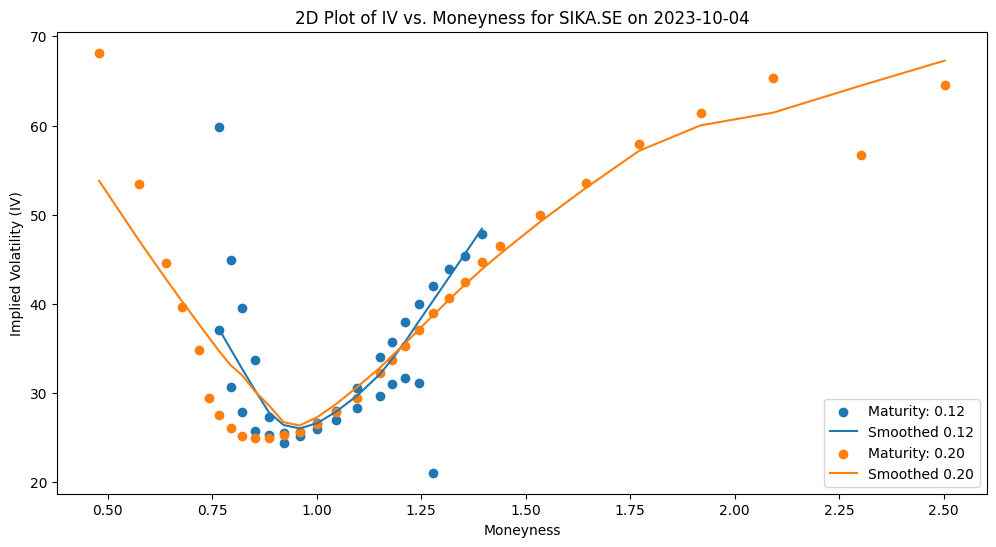

In [ ]:
df = df_new_list[1]
# # Sort the DataFrame by 'moneyness' in ascending order
# df = df.sort_values(by='moneyness', ascending=True)
# # Unique maturities for different plots
maturities = df['maturity'].unique()

plt.figure(figsize=(12, 6))

for mat in maturities:
    subset = df[df['maturity'] == mat]
    # Scatter plot
    plt.scatter(subset['moneyness'], subset['IV'], label=f'Maturity: {mat:.2f}')

    # Apply LOWESS smoothing
    lowess = statsm.nonparametric.lowess(subset['IV'], subset['moneyness'], frac=0.5)

    # Plot the smoothed line
    plt.plot(lowess[:, 0], lowess[:, 1], label=f'Smoothed {mat:.2f}')

plt.title('2D Plot of IV vs. Moneyness for SIKA.SE on 2023-10-04')
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility (IV)')
plt.legend()
plt.show()
plt.close()


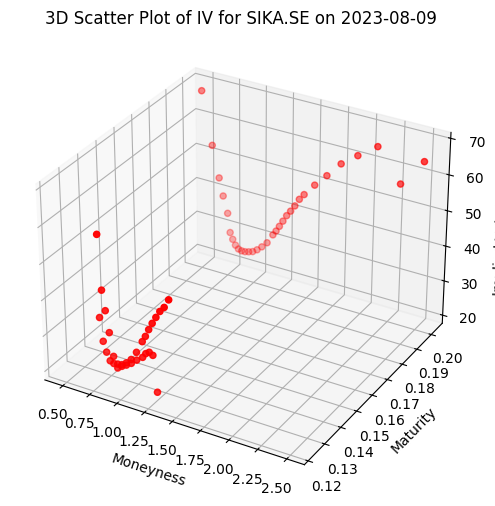

In [ ]:
df = df_new_list[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['moneyness'], df['maturity'], df['IV'], c='r', marker='o')
ax.set_title(f'3D Scatter Plot of IV for SIKA.SE on 2023-08-09')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility (IV)')
plt.show()
plt.close()

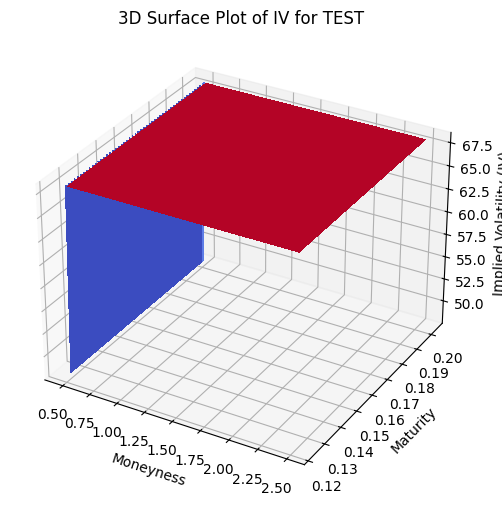

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.linspace(df['moneyness'].min(), df['moneyness'].max(), 100), 
                    np.linspace(df['maturity'].min(), df['maturity'].max(), 100))
Z = np.array([np.interp(x, df['moneyness'], df['IV']) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_title(f'3D Surface Plot of IV for {"TEST"}')
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility (IV)')
plt.show()
plt.close()

# Plotting payoff against product price, calculating RMSE


In [ ]:
pd.set_option('display.max_rows', None) # TODO:
# TODO: Take the values from yq_script
model = 'gbm' #TODO:
dir_list = ['20231114_024525_7'] 
max_sigma = 0.5

# For different methodologies, we want to get the RMSE for the ppd_payous against actual price
# Change to itertools
RMSE_list = []
for uid in dir_list:
    paths_arr, dates = sm.read_sim_data(model, uid, cs.INITIAL_PROD_PRICING_DATE, cs.FINAL_PROD_PRICING_DATE)
    n_sim = len(paths_arr[0])
    n_ppd = len(paths_arr) # Some missing lists in n_ppd
    print(n_sim, n_ppd)

    actual_price = po.get_product_price(cs.FINAL_PROD_PRICING_DATE).rename(columns={'Price': 'actual_price'})
    # Actual price for the product price period
    actual_price = actual_price[actual_price.index >= cs.INITIAL_PROD_PRICING_DATE]
    # logger_yq.info(f'Actual_price df is\n{actual_price}')

    payouts_compare = pd.DataFrame({'ppd_payouts': np.zeros(len(actual_price))})
    payouts_compare.index = pd.to_datetime(actual_price.index)
    payouts_compare = pd.concat([payouts_compare, actual_price], axis=1)
    actual_price.copy(deep=True)

    # Average payouts of all the sim paths on each ppd
    # display(payouts_compare)
    for ppd in range(n_ppd):
        # Need to rename columns first
        # logger_yq.info(f'pdd = {ppd} paths_arr[ppd] is\n{paths_arr[ppd]}')
        # Payouts for all the paths on one day of the price period (multiple paths)
        if (len(paths_arr[ppd]) != 0):
            paths_payout = po.pricing_multiple(paths_arr[ppd])
            payouts_compare.loc[pd.Timestamp(dates[ppd]),'ppd_payouts'] =  np.mean(paths_payout)
        else:
            logger_yq.error(f"Path payouts cannot be 0")
    # Payouts for the entire pricing period
    #display(payouts_compare)


    

10 67


In [ ]:
payouts_compare.head()

,ppd_payouts,actual_price
Date,,
2023-08-09,1052.834728,961.4
2023-08-10,980.987444,968.1
2023-08-11,952.130510,964.3
2023-08-14,1050.296743,964.6
2023-08-15,1053.524283,961.7


0


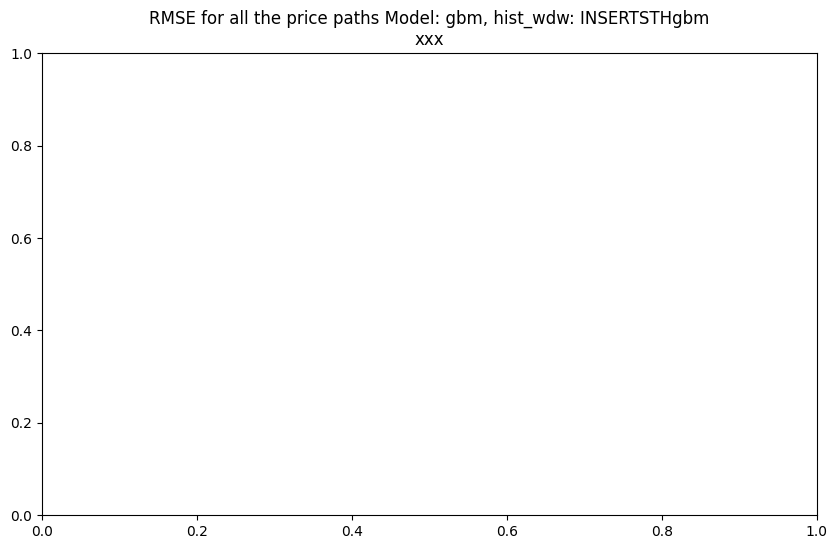

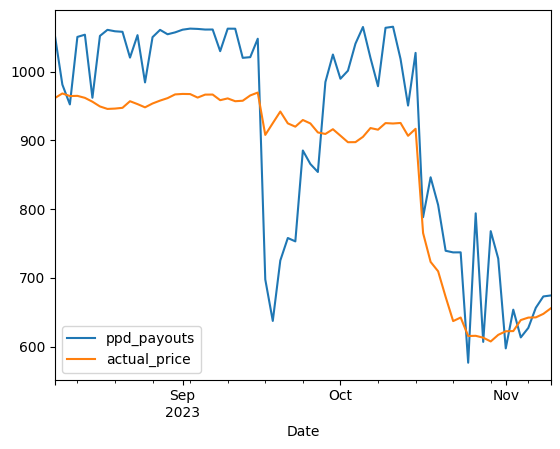

In [ ]:
# TODO: Plot payouts_compare
fig, ax = plt.subplots(figsize=(10,6)) 
if model == 'heston':
    title_str = f"Model: {model}, hist_wdw: INSERTSTH{model}, max_sigma: {max_sigma}"
else:
    # TODO: Do sth for gbm
    title_str = f"RMSE for all the price paths Model: {model}, hist_wdw: INSERTSTH{model}"
    pass
subtitle_str = f"xxx"
plt.title(f"{title_str}\n{subtitle_str}")
payouts_compare.plot()
# # payouts_compare = payouts_compare[payouts_compare['ppd_payouts'] != 0]
# # Replace leading/trailing zeros with NaN
# payouts_compare['ppd_payouts'].replace(to_replace=0, method='ffill', inplace=True)  # Forward fill
# payouts_compare['ppd_payouts'].replace(to_replace=0, method='bfill', inplace=True)  # Backward fill

average = 0
compare_clean = payouts_compare.copy(deep=True)
if model == 'heston':
    # average = np.mean(compare_clean['ppd_payouts'])
    # compare_clean = compare_clean[abs(compare_clean['ppd_payouts'] - average) / average < 0.2]

    compare_clean = compare_clean[(compare_clean.index < pd.Timestamp('2023-09-15')) | (compare_clean.index > pd.Timestamp('2023-10-01'))]
compare_clean = compare_clean[compare_clean['ppd_payouts'] > 0]
print(average)
# display(compare_clean)

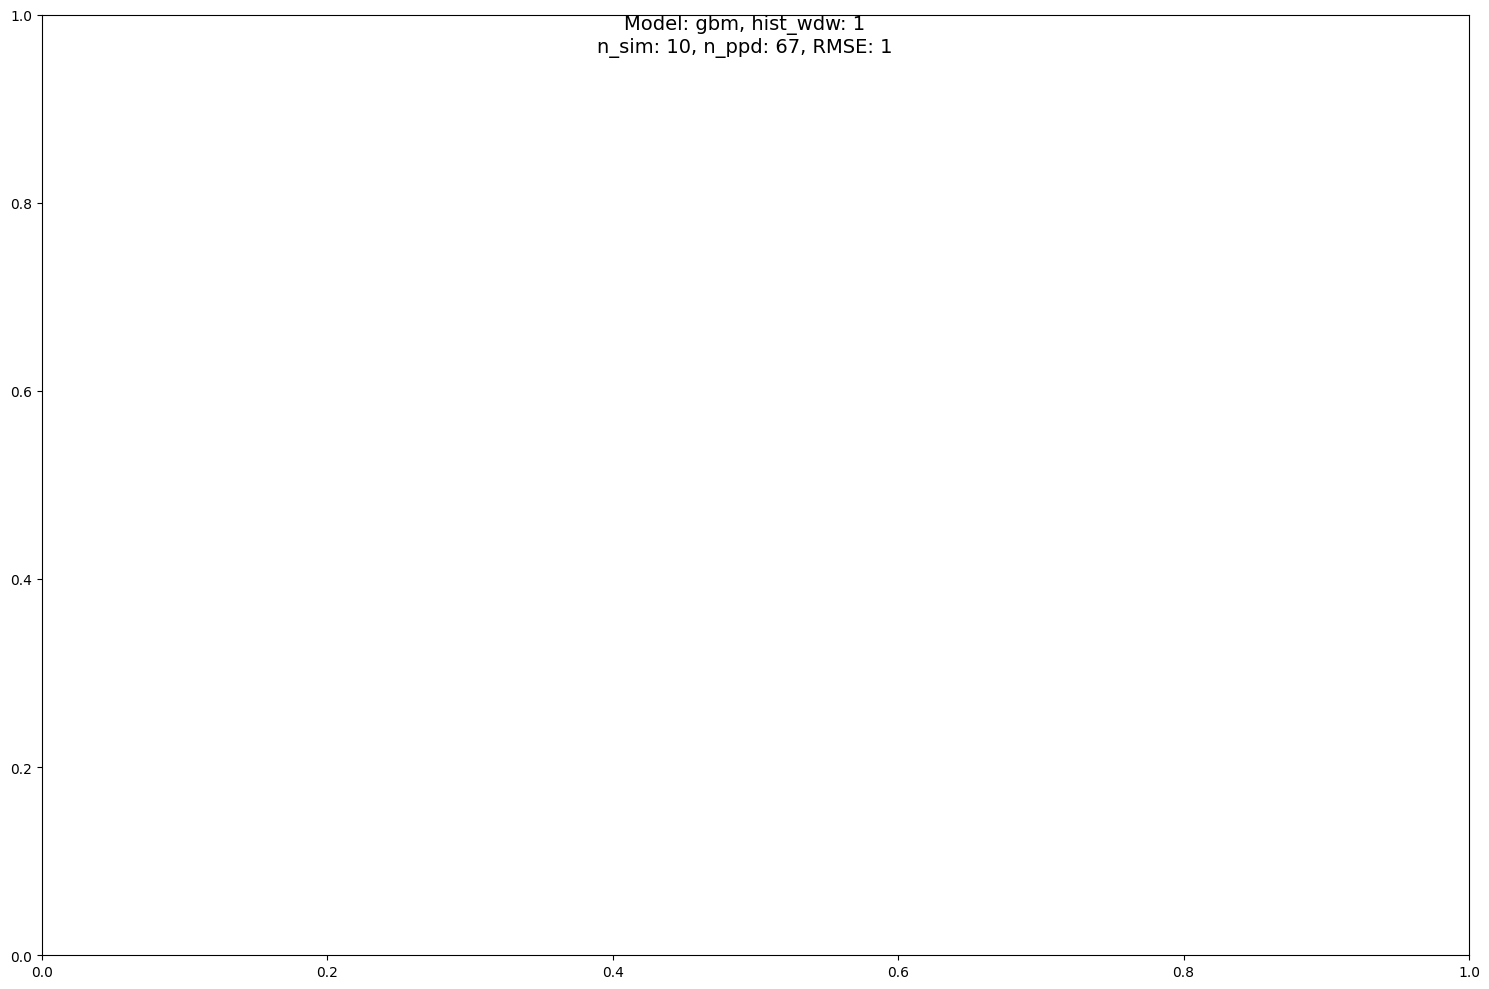

In [ ]:


plt.subplots(figsize=(15, 10))
plt.tight_layout()
title_str = f"Model: {model}, hist_wdw: 1"
subtitle_str = f"n_sim: {n_sim}, n_ppd: {n_ppd}, RMSE: 1"
plt.suptitle(f"{title_str}\n{subtitle_str}", fontsize=14)  # Adjust font size as needed


compare_clean.plot()
plt.close()

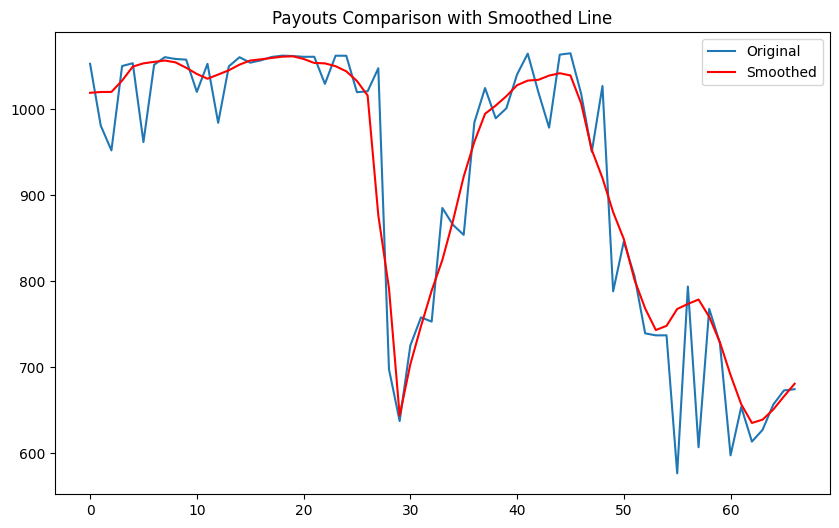

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


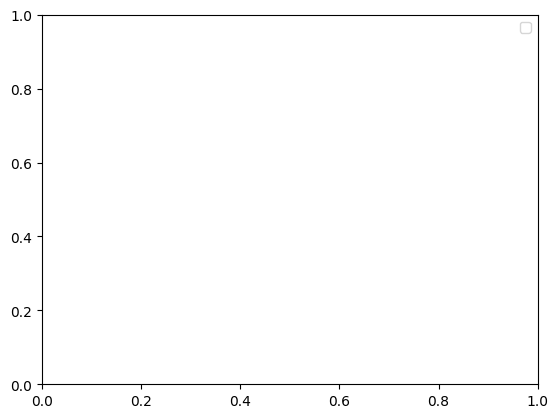

In [ ]:
# Smooth but not that useful
import statsmodels.api as statsm

# compare_clean.plot()

# Assuming payouts_compare has a 'ppd_payouts' column
compare_clean = compare_clean.reset_index(drop=True)
x = compare_clean.index
y = compare_clean['ppd_payouts']

# Lowess smoothing
lowess = statsm.nonparametric.lowess(y, x, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Original')
plt.plot(lowess[:, 0], lowess[:, 1], label='Smoothed', color='red')
plt.title('Payouts Comparison with Smoothed Line')
plt.legend()
plt.show()
plt.legend(loc='upper right')